#Hidden Markov Model (HMM) for Part-of-Speech Tagging

**Pipeline**: Data Preparation → Data Exploration → Splitting for Training & Testing → OOV Handling (<UNK>) → HMM Training → Viterbi Decoding → Evaluation

##Setup

In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

# Data Preparation


### Load Dataset

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')
tagged_sents = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


### Data Exploration

In [ ]:
data = [(word, tag) for sent in tagged_sents for word, tag in sent]
df = pd.DataFrame(data, columns=['word', 'tag'])

total_tokens = len(df)
unique_words = df['word'].nunique()
unique_tags  = df['tag'].nunique()
tag_list     = sorted(df['tag'].unique())

print(f"Total tokens:    {total_tokens:,}")
print(f"Unique words:    {unique_words:,}")
print(f"Unique POS tags: {unique_tags}")
print(f"POS tags:        {', '.join(tag_list)}")

Total tokens:    1,161,192
Unique words:    56,057
Unique POS tags: 12
POS tags:        ., ADJ, ADP, ADV, CONJ, DET, NOUN, NUM, PRON, PRT, VERB, X


In [ ]:
print("Tag Distribution:")
tag_counts = df['tag'].value_counts()
for tag, count in tag_counts.items():
    print(f"  {tag:<8}: {count:,} ({count/total_tokens*100:.2f}%)")

Tag Distribution:
  NOUN    : 275,558 (23.73%)
  VERB    : 182,750 (15.74%)
  .       : 147,565 (12.71%)
  ADP     : 144,766 (12.47%)
  DET     : 137,019 (11.80%)
  ADJ     : 83,721 (7.21%)
  ADV     : 56,239 (4.84%)
  PRON    : 49,334 (4.25%)
  CONJ    : 38,151 (3.29%)
  PRT     : 29,829 (2.57%)
  NUM     : 14,874 (1.28%)
  X       : 1,386 (0.12%)


###Tag Distribution  VS Sentence Length Distribution

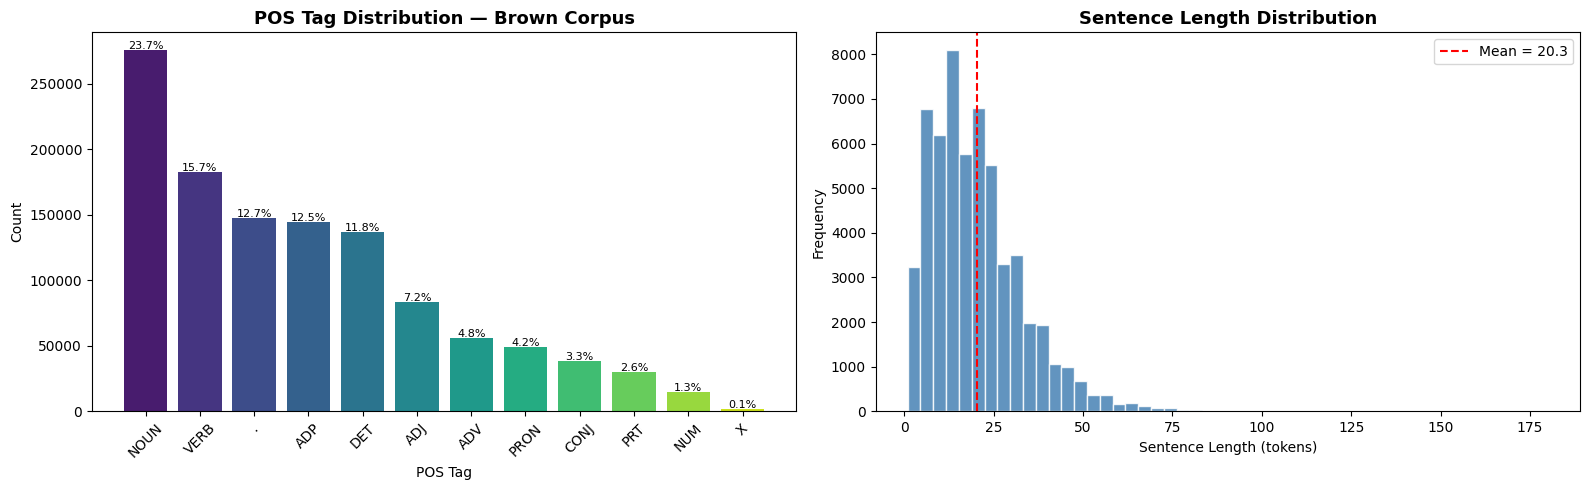


  Sentence length — Min: 1, Max: 180, Mean: 20.3, Median: 18.0


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Tag distribution
tag_counts_sorted = df['tag'].value_counts()
axes[0].bar(tag_counts_sorted.index, tag_counts_sorted.values,
            color=sns.color_palette('viridis', len(tag_counts_sorted)))
axes[0].set_title('POS Tag Distribution — Brown Corpus', fontsize=13, fontweight='bold')
axes[0].set_xlabel('POS Tag')
axes[0].set_ylabel('Count')
for i, (tag, cnt) in enumerate(tag_counts_sorted.items()):
    axes[0].text(i, cnt + 800, f'{cnt/total_tokens*100:.1f}%', ha='center', fontsize=8)
axes[0].tick_params(axis='x', rotation=45)

# Sentence length distribution
sent_lengths = [len(s) for s in tagged_sents]
axes[1].hist(sent_lengths, bins=50, color='steelblue', edgecolor='white', alpha=0.85)
axes[1].set_title('Sentence Length Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Sentence Length (tokens)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(sent_lengths), color='red', linestyle='--',
                label=f'Mean = {np.mean(sent_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n  Sentence length — Min: {min(sent_lengths)}, Max: {max(sent_lengths)}, "
      f"Mean: {np.mean(sent_lengths):.1f}, Median: {np.median(sent_lengths):.1f}")

# Training & Testing

In [ ]:
# Split sentences 80-20
split_start = time.time()
train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)
split_time = time.time() - split_start

print(f"Training sentences: {len(train_sents):,}")
print(f"Testing sentences:  {len(test_sents):,}")
print(f"Training tokens:    {sum(len(s) for s in train_sents):,}")
print(f"Testing tokens:     {sum(len(s) for s in test_sents):,}")
print(f"Split time:         {split_time:.4f}s")


Training sentences: 45,872
Testing sentences:  11,468
Training tokens:    929,265
Testing tokens:     231,927
Split time:         21.8462s


##Token Injection

In [ ]:
unk_start = time.time()

#unknown token
UNK_TOKEN     = "<UNK>"
UNK_THRESHOLD = 1   # words appearing <= 1 time are replaced

train_word_counts = Counter(word for sent in train_sents for word, tag in sent)
known_vocab       = {word for word, cnt in train_word_counts.items() if cnt > UNK_THRESHOLD}

def replace_unk(sentence, vocab):
    return [(word if word in vocab else UNK_TOKEN, tag) for word, tag in sentence]

train_sents_unk = [replace_unk(sent, known_vocab) for sent in train_sents]

# Stats
total_train_tokens = sum(len(s) for s in train_sents)
unk_in_train       = sum(1 for s in train_sents_unk for w, _ in s if w == UNK_TOKEN)
test_words         = {w for s in test_sents for w, _ in s}
oov_types          = test_words - known_vocab
oov_tokens         = sum(1 for s in test_sents for w, _ in s if w not in known_vocab)
total_test_tokens  = sum(len(s) for s in test_sents)

unk_time = time.time() - unk_start

print(f"Original vocab size:      {len(train_word_counts):,}")
print(f"Known vocab (after UNK):  {len(known_vocab):,}")
print(f"UNK threshold:            frequency <= {UNK_THRESHOLD}")
print(f"UNK tokens in training:   {unk_in_train:,} ({unk_in_train/total_train_tokens*100:.2f}%)")
print(f"OOV word types in test:   {len(oov_types):,}")
print(f"OOV tokens in test:       {oov_tokens:,} ({oov_tokens/total_test_tokens*100:.2f}%)")
print(f"UNK injection time:       {unk_time:.4f}s")

Original vocab size:      50,595
Known vocab (after UNK):  27,005
UNK threshold:            frequency <= 1
UNK tokens in training:   23,590 (2.54%)
OOV word types in test:   8,534
OOV tokens in test:       9,662 (4.17%)
UNK injection time:       1.3321s


##Training

In [ ]:
training_start = time.time()

# Build tag and vocab indices from UNK-replaced training data
all_tags  = sorted({tag  for sent in train_sents_unk for _, tag  in sent})
all_words = sorted({word for sent in train_sents_unk for word, _ in sent})

num_tags  = len(all_tags)
num_words = len(all_words)

tag2idx  = {tag:  i for i, tag  in enumerate(all_tags)}
word2idx = {word: i for i, word in enumerate(all_words)}
idx2tag  = {i: tag for tag, i in tag2idx.items()}

print(f"Tags  ({num_tags}):  {all_tags}")
print(f"Vocab ({num_words:,}): includes <UNK>")

# Count tables
init_counts       = np.zeros(num_tags)
transition_counts = np.zeros((num_tags, num_tags))
emission_counts   = np.zeros((num_tags, num_words))

for sent in train_sents_unk:
    if not sent:
        continue
    init_counts[tag2idx[sent[0][1]]] += 1
    for i, (word, tag) in enumerate(sent):
        emission_counts[tag2idx[tag], word2idx[word]] += 1
        if i > 0:
            transition_counts[tag2idx[sent[i-1][1]], tag2idx[tag]] += 1

# Add-k smoothing
k = 0.001

init_probs  = (init_counts + k) / (init_counts.sum() + k * num_tags)
trans_probs = (transition_counts + k) / (transition_counts.sum(axis=1, keepdims=True) + k * num_tags)
emit_probs  = (emission_counts  + k) / (emission_counts.sum(axis=1,  keepdims=True) + k * num_words)

# Log space to avoid underflow in Viterbi
log_init  = np.log(init_probs)
log_trans = np.log(trans_probs)
log_emit  = np.log(emit_probs)

training_time = time.time() - training_start

print(f"\nSmoothing constant k:  {k}")
print(f"Initial counts:        {int(init_counts.sum())} sentences")
print(f"Transition bigrams:    {int(transition_counts.sum()):,}")
print(f"Emission tokens:       {int(emission_counts.sum()):,}")
print(f"Training time:         {training_time:.4f}s")

Tags  (12):  ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
Vocab (27,006): includes <UNK>

Smoothing constant k:  0.001
Initial counts:        45872 sentences
Transition bigrams:    883,393
Emission tokens:       929,265
Training time:         1.7791s


#Visualization

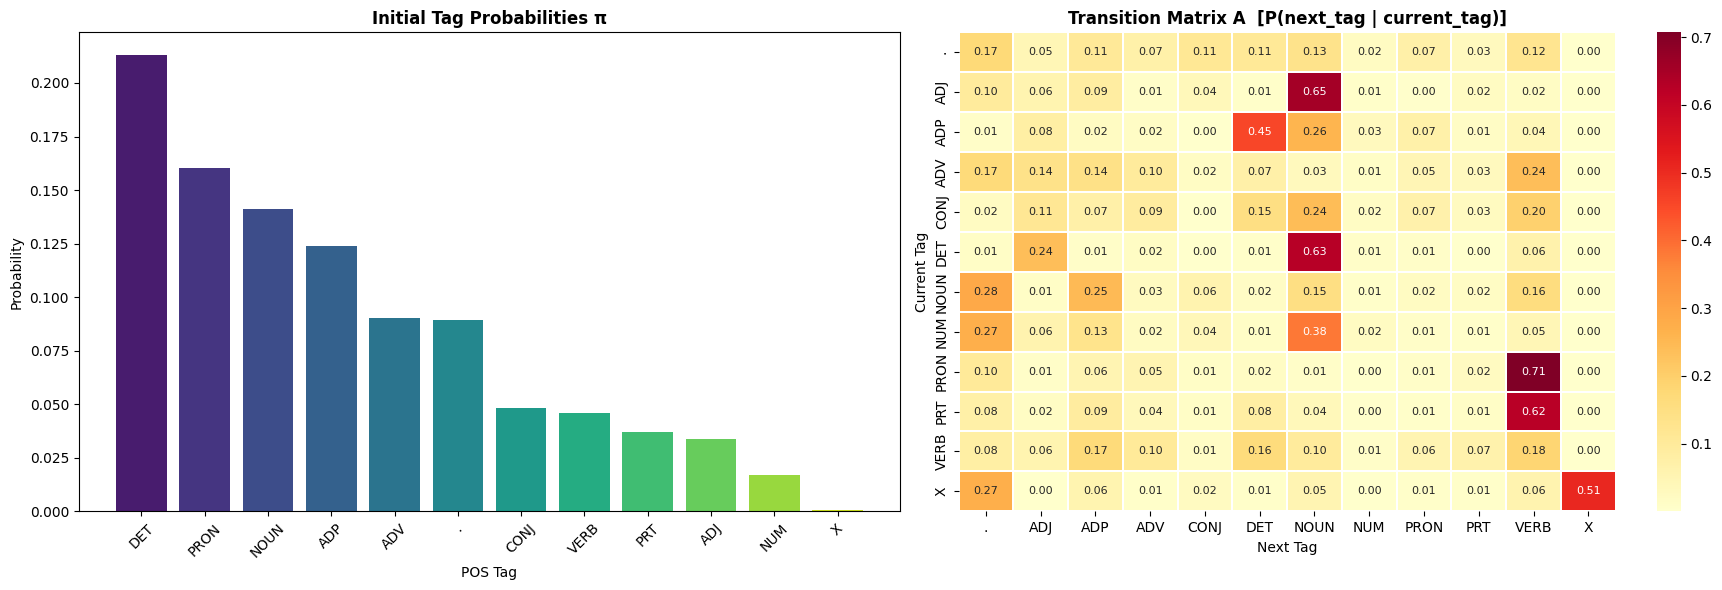

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Initial probability bar chart
sort_idx = np.argsort(init_probs)[::-1]
axes[0].bar([all_tags[i] for i in sort_idx],
            [init_probs[i] for i in sort_idx],
            color=sns.color_palette('viridis', num_tags))
axes[0].set_title('Initial Tag Probabilities π', fontweight='bold')
axes[0].set_xlabel('POS Tag')
axes[0].set_ylabel('Probability')
axes[0].tick_params(axis='x', rotation=45)

# Transition matrix heatmap
trans_df = pd.DataFrame(trans_probs, index=all_tags, columns=all_tags)
sns.heatmap(trans_df, ax=axes[1], cmap='YlOrRd', annot=True, fmt='.2f',
            annot_kws={'size': 8}, linewidths=0.3)
axes[1].set_title('Transition Matrix A  [P(next_tag | current_tag)]', fontweight='bold')
axes[1].set_xlabel('Next Tag')
axes[1].set_ylabel('Current Tag')

plt.tight_layout()
plt.show()

##Viterbi Decoder

In [ ]:
def viterbi_decode(sentence_words, known_vocab,
                   log_init, log_trans, log_emit,
                   word2idx, idx2tag, num_tags,
                   unk_token="<UNK>"):
    T = len(sentence_words)
    if T == 0:
        return []

    # Map OOV words to <UNK>
    words = [w if w in known_vocab else unk_token for w in sentence_words]
    w_idx = [word2idx[w] for w in words]

    viterbi = np.full((T, num_tags), -np.inf)
    backptr = np.zeros((T, num_tags), dtype=int)

    # Initialisation
    viterbi[0] = log_init + log_emit[:, w_idx[0]]

    # Recursion
    for t in range(1, T):
        scores     = viterbi[t-1, :, None] + log_trans          # (N, N)
        backptr[t] = np.argmax(scores, axis=0)
        viterbi[t] = scores[backptr[t], np.arange(num_tags)] + log_emit[:, w_idx[t]]

    # Backtrack
    best_path      = [0] * T
    best_path[T-1] = int(np.argmax(viterbi[T-1]))
    for t in range(T-2, -1, -1):
        best_path[t] = backptr[t+1, best_path[t+1]]

    return [idx2tag[i] for i in best_path]

#Prediction

In [ ]:
prediction_start = time.time()
y_pred = []
y_true = []

for sent in test_sents:
    words     = [w for w, _ in sent]
    true_tags = [t for _, t in sent]
    pred_tags = viterbi_decode(
        words, known_vocab,
        log_init, log_trans, log_emit,
        word2idx, idx2tag, num_tags
    )
    y_pred.append(pred_tags)
    y_true.append(true_tags)

prediction_time   = time.time() - prediction_start
total_time        = training_time + prediction_time
total_test_tokens = sum(len(s) for s in test_sents)
tokens_per_sec    = total_test_tokens / prediction_time

print(f"Test sentences decoded:  {len(test_sents):,}")
print(f"Test tokens decoded:     {total_test_tokens:,}")
print(f"Prediction time:         {prediction_time:.2f}s")
print(f"Throughput:              {tokens_per_sec:,.0f} tokens/sec")
print(f"Total pipeline time:     {total_time:.2f}s")

Test sentences decoded:  11,468
Test tokens decoded:     231,927
Prediction time:         3.95s
Throughput:              58,743 tokens/sec
Total pipeline time:     5.73s


##Evaluation Metrics

In [ ]:
y_true_flat = [t for sent in y_true for t in sent]
y_pred_flat = [t for sent in y_pred for t in sent]

accuracy           = accuracy_score(y_true_flat, y_pred_flat)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_flat, y_pred_flat, average='weighted', zero_division=0
)

print(f"Overall Metrics (weighted average):")
print(f"Accuracy:   {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")

Overall Metrics (weighted average):
Accuracy:   0.9583  (95.83%)
Precision:  0.9588
Recall:     0.9583
F1-Score:   0.9584


##Confusion Matrix

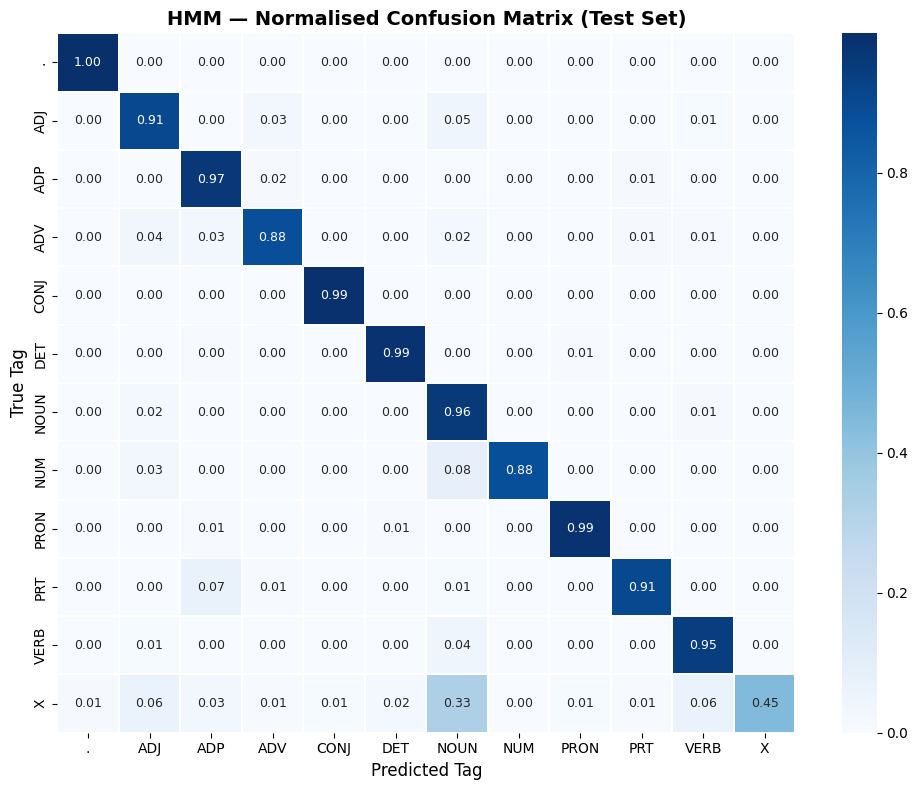

In [ ]:
cm= confusion_matrix(y_true_flat, y_pred_flat, labels=all_tags)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=all_tags, yticklabels=all_tags,
            linewidths=0.3, annot_kws={'size': 9})
plt.title('HMM — Normalised Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Tag', fontsize=12)
plt.ylabel('True Tag', fontsize=12)
plt.tight_layout()
plt.show()

# Per-Tag F1 Chart

F1 score for each POS tag VS How many tokens of each tag exist in the test set

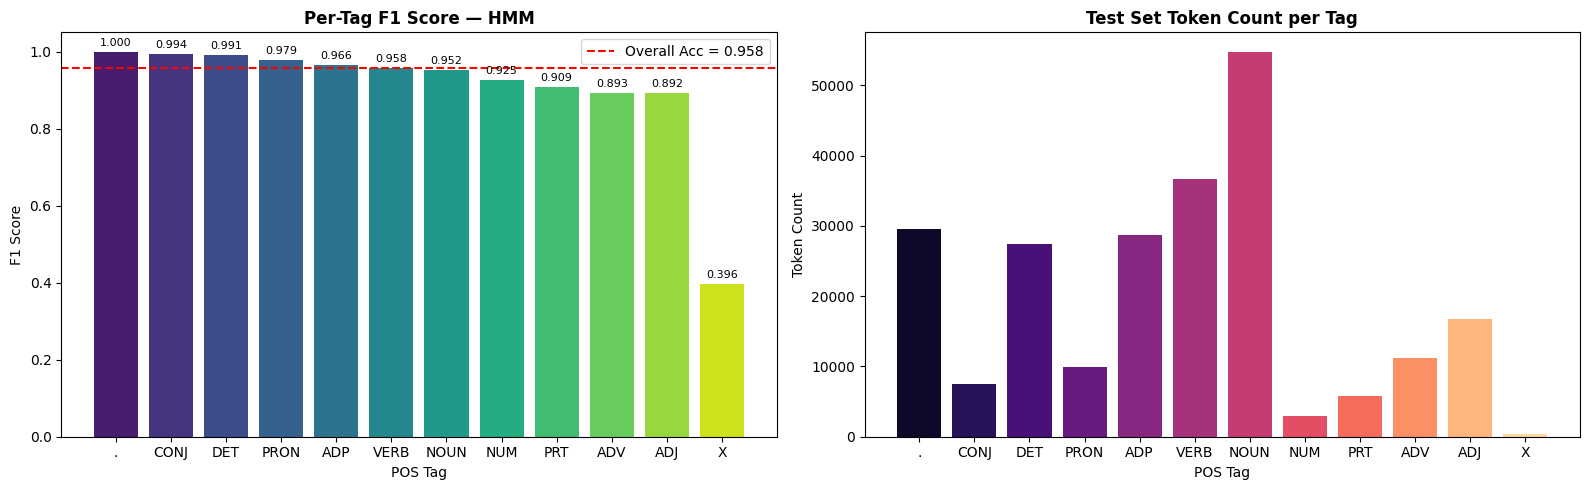

In [ ]:
per_tag_f1      = f1_score(y_true_flat, y_pred_flat, labels=all_tags, average=None, zero_division=0)
per_tag_support = [y_true_flat.count(t) for t in all_tags]
sort_order      = np.argsort(per_tag_f1)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

bars = axes[0].bar([all_tags[i] for i in sort_order],
                   [per_tag_f1[i]      for i in sort_order],
                   color=sns.color_palette('viridis', num_tags))
axes[0].set_ylim(0, 1.05)
axes[0].set_title('Per-Tag F1 Score — HMM', fontweight='bold')
axes[0].set_xlabel('POS Tag')
axes[0].set_ylabel('F1 Score')
axes[0].axhline(accuracy, color='red', linestyle='--', label=f'Overall Acc = {accuracy:.3f}')
axes[0].legend()
for bar, v in zip(bars, [per_tag_f1[i] for i in sort_order]):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.01,
                 f'{v:.3f}', ha='center', va='bottom', fontsize=8)

axes[1].bar([all_tags[i] for i in sort_order],
            [per_tag_support[i] for i in sort_order],
            color=sns.color_palette('magma', num_tags))
axes[1].set_title('Test Set Token Count per Tag', fontweight='bold')
axes[1].set_xlabel('POS Tag')
axes[1].set_ylabel('Token Count')

plt.tight_layout()
plt.show()

##OOV(Out-Of-Vocabulary) Vs Known-word Accuracy

Known-word tokens:   222,265
Known-word accuracy: 97.26%
OOV tokens:          9,662
OOV accuracy:        62.75%
Accuracy gap:        34.51 percentage points


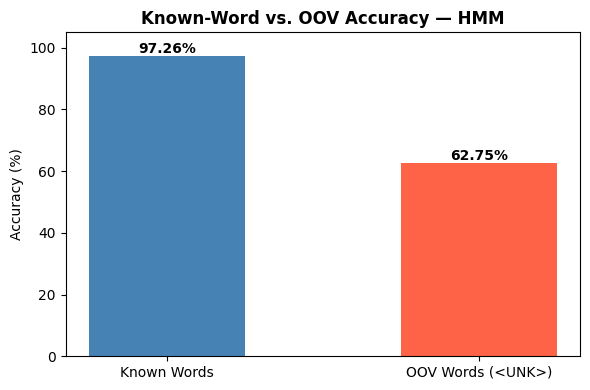

In [ ]:
known_correct = known_total = oov_correct = oov_total = 0

for sent, pred_tags in zip(test_sents, y_pred):
    for (word, true_tag), pred_tag in zip(sent, pred_tags):
        if word in known_vocab:
            known_total   += 1
            known_correct += int(true_tag == pred_tag)
        else:
            oov_total   += 1
            oov_correct += int(true_tag == pred_tag)

known_acc = known_correct / known_total if known_total else 0
oov_acc   = oov_correct   / oov_total   if oov_total   else 0

print(f"Known-word tokens:   {known_total:,}")
print(f"Known-word accuracy: {known_acc*100:.2f}%")
print(f"OOV tokens:          {oov_total:,}")
print(f"OOV accuracy:        {oov_acc*100:.2f}%")
print(f"Accuracy gap:        {(known_acc - oov_acc)*100:.2f} percentage points")

# Bar chart
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Known Words', f'OOV Words (<UNK>)'], [known_acc * 100, oov_acc * 100],
       color=['steelblue', 'tomato'], width=0.5)
ax.set_ylim(0, 105)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Known-Word vs. OOV Accuracy — HMM', fontweight='bold')
for i, v in enumerate([known_acc * 100, oov_acc * 100]):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

##Sample Sentence Prediction

In [ ]:
for i in range(5):
    print(f"\nSentence {i+1}")

    sent_words = [w for w, _ in test_sents[i]]
    max_display = 20

    display_words = sent_words[:max_display]
    display_true  = y_true[i][:max_display]
    display_pred  = y_pred[i][:max_display]
    suffix        = " ..." if len(sent_words) > max_display else ""

    print("Words: " + " ".join(display_words) + suffix)
    print("True:  " + " ".join(display_true)  + suffix)
    print("Pred:  " + " ".join(display_pred)  + suffix)

    errors   = sum(1 for t, p in zip(y_true[i], y_pred[i]) if t != p)
    total_w  = len(y_true[i])
    sent_acc = (total_w - errors) / total_w * 100

    if errors == 0:
        print(f"Result: 100% accuracy")
    else:
        print(f"Result: {errors}/{total_w} errors ({sent_acc:.1f}% accuracy)")


Sentence 1
Words: Open market policy
True:  ADJ NOUN NOUN
Pred:  NOUN NOUN NOUN
Result: 1/3 errors (66.7% accuracy)

Sentence 2
Words: And you think you have language problems .
True:  CONJ PRON VERB PRON VERB NOUN NOUN .
Pred:  CONJ PRON VERB PRON VERB NOUN NOUN .
Result: 100% accuracy

Sentence 3
Words: Mae entered the room from the hallway to the kitchen .
True:  NOUN VERB DET NOUN ADP DET NOUN ADP DET NOUN .
Pred:  NOUN VERB DET NOUN ADP DET NOUN ADP DET NOUN .
Result: 100% accuracy

Sentence 4
Words: This will permit you to get a rough estimate of how much the materials for the shell will cost .
True:  DET VERB VERB PRON PRT VERB DET ADJ NOUN ADP ADV ADJ DET NOUN ADP DET NOUN VERB VERB .
Pred:  DET VERB VERB PRON PRT VERB DET ADJ NOUN ADP ADV ADV DET NOUN ADP DET NOUN VERB NOUN .
Result: 2/20 errors (90.0% accuracy)

Sentence 5
Words: the multifigure `` Traveling Carnival '' , in which action is vivified by lighting ; ;
True:  DET NOUN . VERB NOUN . . ADP DET NOUN VERB VERB ADP V

In [ ]:
print(f"\n  Classification Report:")
print(classification_report(y_true_flat, y_pred_flat,
                             target_names=all_tags, zero_division=0))

# Create a simple summary table
from sklearn.metrics import precision_recall_fscore_support

per_tag_metrics = precision_recall_fscore_support(
    y_true_flat, y_pred_flat, labels=all_tags, zero_division=0
)



  Classification Report:
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29520
         ADJ       0.88      0.91      0.89     16772
         ADP       0.96      0.97      0.97     28768
         ADV       0.90      0.88      0.89     11271
        CONJ       0.99      0.99      0.99      7529
         DET       0.99      0.99      0.99     27474
        NOUN       0.94      0.96      0.95     54822
         NUM       0.98      0.88      0.93      2911
        PRON       0.97      0.99      0.98      9934
         PRT       0.91      0.91      0.91      5853
        VERB       0.97      0.95      0.96     36744
           X       0.36      0.45      0.40       329

    accuracy                           0.96    231927
   macro avg       0.91      0.91      0.90    231927
weighted avg       0.96      0.96      0.96    231927



#Model Summary

In [ ]:
print("MODEL PERFORMANCE SUMMARY")
print("=" * 25)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

MODEL PERFORMANCE SUMMARY
Accuracy:  0.9583
Precision: 0.9588
Recall:    0.9583
F1-Score:  0.9584
